# Turnaround tuesday

- Instrument S&P 500 (SPY)
- Buy if market closed on Monday below Friday close
- Hold position until next (Tuesday) close

# Load assets history

We will use yahoo finance client to load dividends and prices history for our `ASSETS`.

In [1]:
# pip install --user pandas numpy datetime scipy pandas_datareader yfinance

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime, date, timedelta

yf.pdr_override()

In [62]:
INSTRUMENT = 'SPY'

def load_max_history(assets):
  df = None

  for asset in assets:
    data = yf.Ticker(asset).history(period='max')
    columns = pd.MultiIndex.from_product(
      [data.columns, [asset]],
      names=['property', 'asset']
    )
    multi_level_df = pd.DataFrame(data.values, index=data.index, columns=columns)
    # display(multi_level_df.columns.to_numpy())
    if df is None:
      df = multi_level_df
    else:
      df = df.join(multi_level_df)

  df = df[sorted(df.columns)]
  return df.dropna()

df = load_max_history([INSTRUMENT])[['Close', 'Dividends']]
df['DayOfWeek'] = df.index.map(lambda ts: ts.weekday())
df.head()

property,Close,Dividends,DayOfWeek
asset,SPY,SPY,
Date,,,
1993-01-29,25.627357,0.0,4
1993-02-01,25.809599,0.0,0
1993-02-02,25.864300,0.0,1
1993-02-03,26.137709,0.0,2
1993-02-04,26.247065,0.0,3


In [83]:
cash = 50000 # initial cash
portfolio = []

SLIPPAGE = 0.02 # in stock price
FEE = 0.02 # per stock

def flatten_portfolio(portfolio): 
  dict = {}
  for item in portfolio:
    dict[item['asset']] = item['amount']
  return dict

results = {'portfolio_value': [], 'cash': [], 'portfolio': []}

# source_df = df[:30]
source_df = df
for i in range(2, len(source_df) + 1):
  history = source_df[:i]
  last_bar = history.iloc[-1]
  prev_bar = history.iloc[-2]

  last_price = last_bar.Close[INSTRUMENT]
  if last_bar.name.weekday() == 0: # is Monday
    if last_price < prev_bar.Close[INSTRUMENT]:
      # open position
      amount = int(cash / last_price)
      if amount > 0:
        cash -= amount * (last_price + SLIPPAGE)
        cash -= amount * FEE
        portfolio = [{'asset': INSTRUMENT, 'amount': amount}]
  elif last_bar.name.weekday() == 1 and len(portfolio): # is Tuesday and we have a position
    # add dividends if any
    cash += last_bar.Dividends[INSTRUMENT]
    # close the position
    amount = portfolio[0]['amount'] 
    cash += amount * (last_price - SLIPPAGE)
    cash -= amount * FEE
    portfolio = []

  portfolio_value = cash
  for item in portfolio:
    portfolio_value += last_bar.Close[item['asset']] * item['amount']

  results['portfolio_value'].append(portfolio_value)
  results['cash'].append(cash)
  results['portfolio'].append(flatten_portfolio(portfolio))

result_df = pd.DataFrame(results, index=source_df.index[1:])

result_df.head()

,portfolio_value,cash,portfolio
Date,,,
1993-02-01,50000.0,50000.0,{}
1993-02-02,50000.0,50000.0,{}
1993-02-03,50000.0,50000.0,{}
1993-02-04,50000.0,50000.0,{}
1993-02-05,50000.0,50000.0,{}


In [84]:
result_df.tail()

,portfolio_value,cash,portfolio
Date,,,
2022-01-10,111277.727760,20.835426,{'SPY': 239}
2022-01-11,112281.525426,112281.525426,{}
2022-01-12,112281.525426,112281.525426,{}
2022-01-13,112281.525426,112281.525426,{}
2022-01-14,112281.525426,112281.525426,{}


In [85]:
# dumping results to HTML could be useful for debugging

# with open('tt_results.html', 'w') as file:
#   file.write(df.join(result_df).to_html())

# Total annualized returns

In [86]:
first = result_df.iloc[0]
last = result_df.iloc[-1]

years = (last.name - first.name).days / 365.25

annualized_return = (last['portfolio_value']  / first['portfolio_value']) ** (1/years) - 1

print(
  """Annualized return is: %.2f%%
over the period of %.2f years
from %s to %s""" % (
    100 * annualized_return,
    years,
    date.fromtimestamp(first.name.timestamp()), 
    date.fromtimestamp(last.name.timestamp())
  )
)


Annualized return is: 2.83%
over the period of 28.95 years
from 1993-02-01 to 2022-01-14


# Overall performance

Initial investment at 1993-02-01: 10000
Last value at 2022-01-14: 22456.31


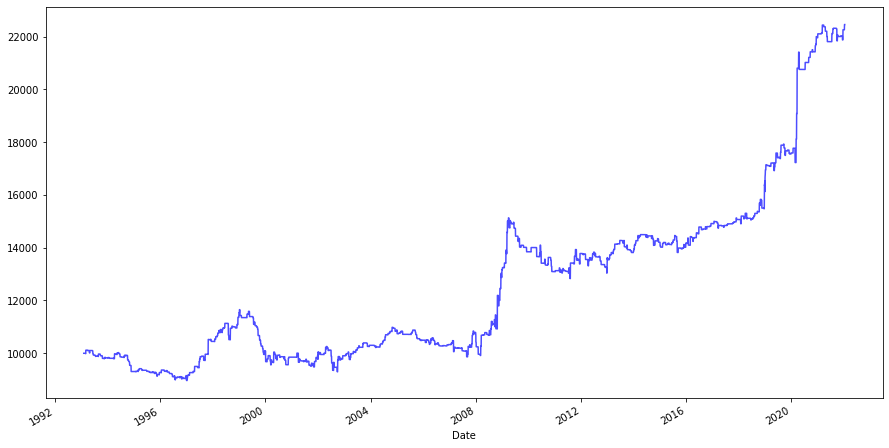

In [87]:
log_returns = np.log(result_df.portfolio_value).diff()

cum_returns = log_returns.cumsum() 

CAPITAL = 10000

perf = CAPITAL * np.exp(cum_returns)
plt.figure()
perf.plot(figsize=(15,8), color='b', alpha=0.7)

print(f'Initial investment at {perf.index[0].date()}: {CAPITAL}')
print(f'Last value at {perf.index[-1].date()}: {perf[-1]:.2f}')

In [88]:
TRADING_DAYS_YEARLY = 252
# RISK_FREE_RATE = 0.02
RISK_FREE_RATE = 0.00

annual_return = np.exp(log_returns.mean() * TRADING_DAYS_YEARLY) - 1
annual_volatility = log_returns.std() * np.sqrt(TRADING_DAYS_YEARLY)

sharpe_ratio = (annual_return - RISK_FREE_RATE) / annual_volatility

annualized_downside = log_returns.loc[log_returns<0].std() * np.sqrt(TRADING_DAYS_YEARLY)
sortino_ratio = (annual_return - RISK_FREE_RATE) / annualized_downside  

sortino_ratio = (annual_return - RISK_FREE_RATE) / annualized_downside  

print(
  f"""Annulaized return {(annual_return * 100):.2f}%
Annualized volatility {(annual_volatility * 100):.2f}%
Sharpe ratio {sharpe_ratio:.2f}
Sortino ratio {sortino_ratio:.2f}
""" 
)

Annulaized return 2.83%
Annualized volatility 6.64%
Sharpe ratio 0.43
Sortino ratio 0.29



# Returns by month/by year

In [89]:

def montly_results(result_df):
  initial_value = result_df['portfolio_value'][0]

  grouping = pd.MultiIndex.from_tuples(
    zip(result_df.index.year, result_df.index.month),
    names=['year', 'month']
  )

  by_month = result_df.groupby(by=grouping).last()[['portfolio_value']]
  by_month = by_month.join(by_month.shift(1).add_prefix('prev_')).fillna(initial_value)

  table = pd.DataFrame(
    {
      'change': 100 * (by_month['portfolio_value'] / by_month['prev_portfolio_value'] - 1),
    },
    index = grouping
  ).dropna().reset_index()

  montly_results = table.pivot_table(index=['year'], columns=['month'], values=['change'])

  grouping = result_df.index.year
  by_year = result_df.groupby(by=grouping).last()[['portfolio_value']]
  by_year = by_year.join(by_year.shift(1).add_prefix('prev_')).fillna(initial_value)

  montly_results['total'] = 100 * (by_year['portfolio_value'] / by_year['prev_portfolio_value'] - 1)

  return montly_results

pd.options.display.float_format = lambda x: 'N/A' if pd.isna(x) else f'{x:.2f}%'
display(montly_results(result_df))
pd.options.display.float_format = None 


change                                                                 \
month      1      2      3      4      5      6      7      8      9     10   
year                                                                          
1993     NaN  0.00%  1.08% -0.03%  0.00% -1.71% -0.39%  0.80% -0.64% -1.02%   
1994  -0.17%  0.00% -0.02%  1.60%  0.60% -1.57% -0.16%  0.70%  0.02% -2.59%   
1995   0.12%  0.57%  0.47% -0.59% -0.04% -0.44% -0.11% -0.30%  0.02% -0.05%   
1996   1.01% -0.51%  0.29% -0.59% -0.61% -1.28% -0.46%  0.30% -0.30%  0.19%   
1997   2.27%  0.99% -0.08%  2.61%  0.00%  1.84%  2.22% -1.61%  2.37%  5.62%   
1998   0.88%  0.83%  2.27%  0.05%  0.72%  1.63%  0.00% -5.59%  4.91% -0.22%   
1999  -0.87% -0.71%  0.00%  1.16% -0.81%  0.00% -1.84% -1.66% -2.92% -2.96%   
2000  -2.98%  1.28% -2.24%  3.68% -2.43%  1.25% -0.53%  0.00% -1.35% -1.74%   
2001   0.00%  0.00%  1.54% -2.80% -0.14% -0.17% -0.24% -1.27% -0.35% -0.31%   
2002   2.61% -0.73%  0.48%  2.56% -1.47%  0.14% -7.56%  1.22% -1.82%  4.85%   
2003   0.80%  0.66% -2.10%  1.49%  0.49%  0.83%  1.07%  0.00%  1.62%  0.00%   
2004   0.00% -0.27% -0.35% -0.01%  1.14%  1.33%  2.01%  0.46%  0.71%  1.43%   
2005  -1.13%  0.26% -0.66%  0.00%  0.00% -0.02%  0.49%  1.02% -1.57% -1.45%   
2006  -0.82%  0.97% -1.64%  1.56% -0.07% -1.33%  0.38% -1.09%  0.00%  0.04%   
2007   0.67% -3.24%  1.31% -0.07%  0.03% -0.92% -0.12% -2.14%  3.71%  0.00%   
2008  -5.02% -2.75%  7.22%  0.15%  0.79% -0.93%  2.23%  1.62%  3.20%  6.45%   
2009   0.62%  4.98%  8.78% -1.10% -0.41% -1.11% -2.05% -0.62% -1.78% -0.55%   
2010   0.00%  1.16%  0.00% -2.45%  0.01% -1.84%  0.00% -0.55%  0.26%  1.92%   
2011   0.28%  0.00%  0.16%  0.46% -0.68% -0.14%  0.58%  1.81% -0.20%  3.97%   
2012  -0.30%  0.18% -1.53% -0.09% -0.06%  2.20% -1.26% -0.05% -1.07% -1.05%   
2013   2.51%  1.68%  0.44%  1.85%  0.09%  0.90% -0.06% -1.62% -0.32% -0.46%   
2014   2.16%  0.65%  1.23%  0.36%  0.00% -0.67%  0.34%  0.00% -0.90% -0.40%   
2015  -1.31%  1.26% -0.60%  0.42% -0.34%  0.61%  1.78% -1.48% -1.83% -0.24%   
2016   1.44% -1.91%  2.11% -0.06%  1.25%  1.52%  0.01% -0.50%  0.58%  0.03%   
2017   0.52% -0.03% -0.97%  0.03% -0.13%  0.10%  0.21%  0.21%  0.03%  0.49%   
2018  -1.05%  1.93% -0.54% -0.16%  0.16% -0.22%  0.84%  0.61%  0.39%  3.07%   
2019   3.69%  0.00%  0.55%  0.04%  0.03%  1.11% -0.18%  2.92% -0.59% -0.63%   
2020   1.02% -3.05% 20.76% -0.24%  0.00%  0.00%  1.27% -0.01%  1.93%  0.01%   
2021   0.66%  0.10%  1.11% -0.75% -1.78%  0.00%  1.41%  0.90% -2.14%  0.75%   
2022   0.89%    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                      total  
month     11     12          
year                         
1993   0.21%  0.00%  -1.73%  
1994  -3.69%  0.00%  -5.27%  
1995  -0.87%  0.85%  -0.40%  
1996  -0.47% -0.82%  -3.22%  
1997   0.03% -0.73%  16.46%  
1998  -0.44%  5.28%  10.37%  
1999  -2.99%  0.38% -12.55%  
2000   2.97%  0.00%  -2.31%  
2001   2.14%  0.85%  -0.83%  
2002   0.40%  1.21%   1.37%  
2003  -1.28%  0.41%   4.00%  
2004  -0.32% -0.57%   5.65%  
2005  -0.65%  0.11%  -3.57%  
2006   0.35%  0.11%  -1.57%  
2007   5.96% -0.52%   4.44%  
2008  -1.49%  9.64%  22.06%  
2009   0.00% -1.20%   5.14%  
2010  -3.92% -0.02%  -5.43%  
2011  -2.88%  1.90%   5.24%  
2012  -0.58% -0.20%  -3.80%  
2013  -0.29% -0.06%   4.68%  
2014   0.00% -0.36%   2.38%  
2015   0.26%  1.24%  -0.31%  
2016   0.15%  0.63%   5.31%  
2017   0.98% -0.39%   1.02%  
2018  -2.09%  6.47%   9.53%  
2019   0.18% -0.62%   6.58%  
2020  -0.01%  2.50%  24.82%  
2021   0.12%  1.04%   1.37%  
2022     NaN    NaN   0.89%

# Drawdown analysis

Text(0, 0.5, 'Drawdown, %')

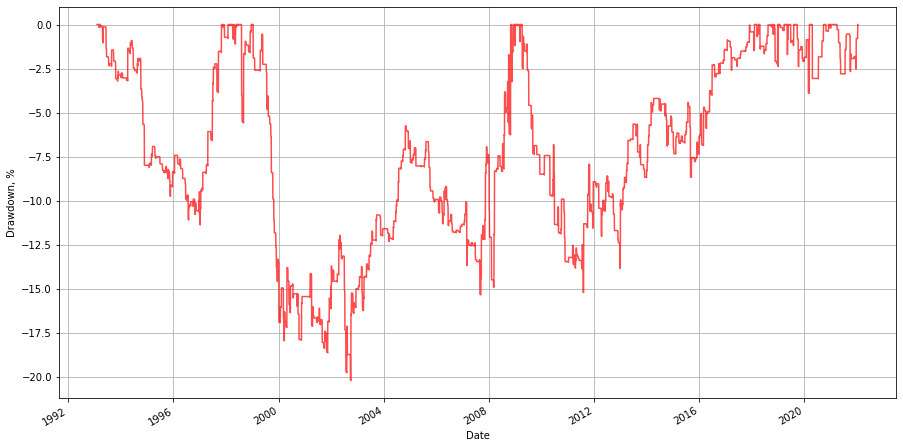

In [90]:
last_peak = cum_returns.cummax()

log_dd = cum_returns - last_peak

pct_dd = (np.exp(log_dd) - 1) * 100

ax = pct_dd.plot(figsize=(15,8), color='r', alpha=0.7)
ax.grid(axis='both')
ax.set_ylabel('Drawdown, %')

# plt.savefig('drawdown_evaluation.svg')


## Longest/max drawdowns

In [91]:

def find_true_streaks(array):
  # finds all "True" streaks in array from longest to shortest

  masked = np.concatenate(([False], array, [False]))       
  true_streaks = np.flatnonzero(masked[1:] != masked[:-1]).reshape(-1, 2) 
  ends = true_streaks[:,1]
  true_streaks_descending = (true_streaks[:,1] - true_streaks[:,0]).argsort()[::-1]
  return true_streaks[true_streaks_descending]

dd_streaks = find_true_streaks(pct_dd.values != 0)

def print_streak(n):
  start, end = dd_streaks[n]
  days = (pct_dd.index[end] - pct_dd.index[start]).days
  years = days / 365.25
  months = years * 12

  print(
    f"""#{n + 1}: Drawdown: {days} days = {months:.2f} months = {years:.2f} years
From {pct_dd.index[start].date()} to {pct_dd.index[end].date()}""" 
  )

print("Longest drawdowns")
for i in range(5):
  if dd_streaks.size <= i: break
  print_streak(i)

if dd_streaks.size == 0:
  print("No drawdown found")

print()
max_dd_index = np.argmin(pct_dd)
print(f"""Max drawdown {pct_dd.iloc[max_dd_index]:.2f}% on {pct_dd.index[max_dd_index].date()}""")

Longest drawdowns
#1: Drawdown: 3578 days = 117.55 months = 9.80 years
From 1999-01-11 to 2008-10-28
#2: Drawdown: 3228 days = 106.05 months = 8.84 years
From 2009-04-06 to 2018-02-06
#3: Drawdown: 1681 days = 55.23 months = 4.60 years
From 1993-03-22 to 1997-10-28
#4: Drawdown: 288 days = 9.46 months = 0.79 years
From 2021-03-29 to 2022-01-11
#5: Drawdown: 169 days = 5.55 months = 0.46 years
From 2019-09-23 to 2020-03-10

Max drawdown -20.22% on 2002-09-30


## Drawdown quantiles

Quantiles:
50.0% of time expected drawdown is no more than 5.26% theoretically or 7.64% actually
75.0% of time expected drawdown is no more than 10.52% theoretically or 11.39% actually
95.0% of time expected drawdown is no more than 22.73% theoretically or 16.03% actually
99.0% of time expected drawdown is no more than 34.94% theoretically or 18.06% actually
Max DD was 20.22%
Last DD (2022-01-14) was -0.00%


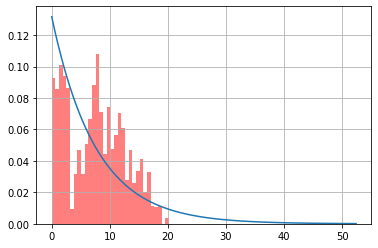

In [92]:
from scipy.stats import expon

nonzero_dd_days = -pct_dd[pct_dd < 0].sort_values()
size = nonzero_dd_days.size

nonzero_dd_days.hist(bins=32, alpha=0.5, density=True, color='red')

params = expon.fit(nonzero_dd_days)

def quantile(p):
  return expon.ppf(p, *params)

xs = np.linspace(quantile(0.001), quantile(0.999), 100)
plt.plot(xs, expon.pdf(xs, *params))

def print_quantile(p):
  theoretical = quantile(p)
  real = nonzero_dd_days[int(size * (1 - p))]
  print(f'{p * 100}% of time expected drawdown is no more than {theoretical:.2f}% theoretically or {real:.2f}% actually')

print('Quantiles:')
for p in [0.50, 0.75, 0.95, 0.99]:
  print_quantile(p)

print(f'Max DD was {nonzero_dd_days[0]:.2f}%')
print(f'Last DD ({pct_dd.index[-1].date()}) was {-pct_dd[-1]:.2f}%')